In [1]:
!pip install matplotlib
#mc cp s3/tordjx ummt --recursive

In [2]:
#%%
from Modele_decodeur_maison import *
from Pipeline import *
from Trainer import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 50

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size)
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head = 4 
num_encoder_layers = 2
num_decoder_layers = 2
dim_feedforward = 196
dropout = 0.1
activation = nn.Softmax(dim=2)
embedding_dim = 196

model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"]).to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"]).to(device)

#IF WE WANT TO LOAD PREVIOUSLY TRAINED MODEL
# model_en.load_state_dict(torch.load("model_en"))
# model_fr.load_state_dict(torch.load("model_fr"))

In [3]:
# val_features  = np.load(fs.open('tordjx/val-resnet50-res4frelu.npy'))
# train_features  = np.load(fs.open('tordjx/train-resnet50-res4frelu.npy'))
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
train_features  = np.load("tordjx/train-resnet50-res4frelu.npy")
val_features = np.load("tordjx/val-resnet50-res4frelu.npy")

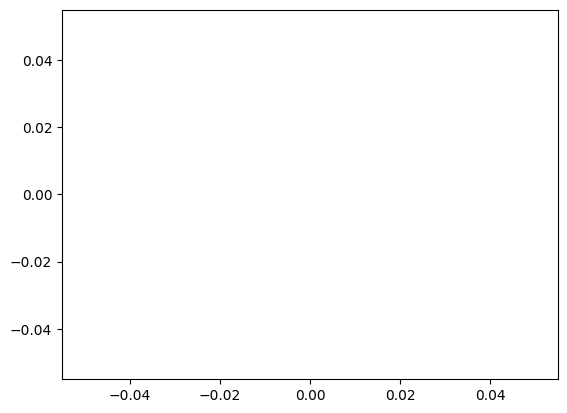

In [4]:
plt.plot(model_fr.loss_list)
plt.plot(model_en.loss_list)

In [5]:

train_features_reshape= torch.from_numpy(train_features.reshape(train_features.shape[0]//batch_size ,batch_size ,1024, 196)).to(dtype = torch.float32)
#Est ce que cette commande est réellement safe ? Demander !
train_data_fr = [tokenized_fr, train_features_reshape]
train_data_en = [tokenized_en, train_features_reshape]
# Y=train_auto_encoding(model_fr,tokenized_fr)
# Y=train_auto_encoding(model_en,tokenized_en)
# Y= cycle_consistency_train(model_fr,model_en,tokenized_fr,tokenized_en)
mixed_train(model_fr,model_en,train_data_fr,train_data_en,200,50, True,[0,1])


/opt/mamba/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


encoded text
tensor([[[-1.9216,  1.5823, -1.6042,  ...,  0.3483,  0.4740, -0.8048],
         [-1.1924,  2.7994, -0.9599,  ..., -0.1083, -1.6317, -0.3937],
         [-0.9910,  1.3010, -1.1089,  ...,  0.3298,  0.1764,  1.0415],
         ...,
         [-1.1020, -0.2576,  0.3624,  ...,  0.0919, -1.8502,  1.5237],
         [-0.8437, -0.1549,  0.2722,  ...,  0.1474, -0.6707,  1.4390],
         [-1.1025, -0.1115,  0.4203,  ...,  0.0274, -1.7502,  1.1815]],

        [[-0.3433,  0.7285, -2.1490,  ...,  0.1738,  0.1288, -0.3019],
         [-1.6520,  1.1623, -1.3228,  ...,  0.4966,  0.2340,  0.5218],
         [-0.6979,  0.1653, -0.4400,  ...,  0.3130,  0.1332,  1.4864],
         ...,
         [-0.8053, -0.8575,  0.7133,  ..., -0.0141, -0.1263,  1.6176],
         [-0.1551, -0.6998,  0.6117,  ..., -0.0998, -1.5175,  1.6428],
         [ 0.1415, -1.2120,  0.6154,  ..., -0.1338, -1.5587,  1.9885]],

        [[-0.6778,  0.4106, -1.5300,  ...,  0.1624, -0.4950, -0.9380],
         [-0.4491, -0.6547, -0.3

KeyboardInterrupt: 

In [ ]:
#%%
def tensor_to_sentence(output,inv_dic):
    result = [inv_dic[int(x)] for x in output]
    sentence = ""
    for word in result : 
        if word == "DEBUT_DE_PHRASE" :
            pass
        elif '@@' in word: 
            sentence+=word[:-2]
        elif word == "FIN_DE_PHRASE" :
            break 
        else :
            sentence+=word +" "
    return sentence

def traduit(model_A,model_B,data, inv_map):
    model_en.eval()
    model_fr.eval()
    output = torch.argmax(cycle_consistent_forward(model_A,model_B,data),dim = 2)[j]
    return tensor_to_sentence(output.view(-1),inv_map)

i = np.random.randint(len(tokenized_en)//50)
j = np.random.randint(50)
data,target = get_batch(tokenized_en, i)

print("Phrase à traduire : \n" + tensor_to_sentence(target[j],inv_map_en)+ "\n Phrase traduite : \n "+ traduit(model_en,model_fr,data, inv_map_fr))


#%%

In [ ]:
torch.save(model_fr.state_dict(), "model_fr")
torch.save(model_en.state_dict(), "model_en")
import os
import s3fs
import pandas
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
fs.upload("model_fr","tordjx/model_fr")
fs.upload("model_en","tordjx/model_fr")

In [ ]:
data ,_= get_batch(tokenized_fr, 0 )
model_fr(data)